In [1]:
#Genetic Algorithm to Trade Stocks Based on Indicators (GATSBI) v1.0
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
from statistics import mean
from copy import deepcopy

In [2]:
BASE_URL = 'https://paper-api.alpaca.markets'
ALPACA_API_KEY = 'PKH15E01MGRA54FBEYRI'
ALPACA_SECRET_KEY = '4U5Q9fPaNDGp8Krj2lYG5NOxjYqqftYQWAlzmxwe'

api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
                    base_url=BASE_URL, api_version='v2')

transaction_type = ['buy', 'sell']

In [11]:
class Agent:
    def __init__(self, data, g):
        self.g = g
        self.data = data
    def randomize(self):
        self.g = []
        self.g.append(random.randint(2,100))
        self.g.append(random.randint(2, 100))
        self.g.append(random.randing(2,100))
        self.g.append(random.randint(2, 100))
    def execute(self):
        self.data['SUP_THRESH'] = self.data['close'].ewm(span=self.g[0], adjust=False).mean()
        self.data['SUP_LIMIT'] = self.data['close'].ewm(span=self.g[1], adjust=False).mean()
        self.data['RES_THRESH'] = self.data['close'].ewm(span=self.g[2], adjust=False).mean()
        self.data['RES_LIMIT'] = self.data['close'].ewm(span=self.g[3], adjust=False).mean()
        self.data['signal'] = self.data['close']
        last_transaction = 'none'
        signal_list = []
        for i in range(len(self.data['close'])):
            price = self.data['close'][i]
            sup_thresh = self.data['SUP_THRESH'][i]
            sup_limit = self.data['SUP_LIMIT'][i]
            res_thresh = self.data['RES_THRESH'][i]
            res_limit = self.data['RES_LIMIT'][i]
            if sup_limit < price and price < sup_thresh:
                if last_transaction == 'buy':
                    signal_list.append('none')
                else:
                    signal_list.append('buy')
                    last_transaction = 'buy'
            elif res_thresh < price and price < res_limit:
                if last_transaction == 'sell':
                    signal_list.append('none')
                else:
                    signal_list.append('sell')
                    last_transaction = 'sell'
            else:
                signal_list.append('none')
        
        self.data['signal'] = signal_list
        self.calculate_fitness()
        
        return self.data
    
    def calculate_fitness(self):
        self.transaction_data = self.data[self.data['signal'].isin(transaction_type)]
        signal = self.transaction_data['signal'].tolist()
        close = self.transaction_data['close'].tolist()
        self.fitness = 0.0
        for i in range(1,len(signal)):
            if signal[i-1] == 'buy' and signal[i] == 'sell':
                self.fitness = self.fitness + (close[i] - close[i-1])
                #print('buy-sell performance: ' + str((close[i] - close[i-1])))
            elif signal[i-1] == 'sell' and signal[i] == 'buy':
                self.fitness = self.fitness + (close[i-1] - close[i])
                #print('sell-buy performance: ' + str((close[i-1] - close[i])))
        return self.fitness
    
    def plot(self):
        plt.figure(figsize=(15,5))
        plt.plot(self.data['close'])
        plt.plot(self.data['SUP_THRESH'])
        plt.plot(self.data['SUP_LIMIT'])
        plt.plot(self.data['RES_THRESH'])
        plt.plot(self.data['RES_LIMIT'])

        plt.plot(self.data[self.data['signal'] == 'buy'].index,
                 self.data['close'][self.data['signal'] == 'buy'],
                 '^', markersize=8, color='g', label='buy')

        plt.plot(self.data[self.data['signal'] == 'sell'].index,
                 self.data['close'][self.data['signal'] == 'sell'],
                 'v', markersize=8, color='r', label='sell')

        plt.xlabel("Date")
        plt.ylabel("Close Price ($)")
        plt.legend()
        plt.show()
        
    

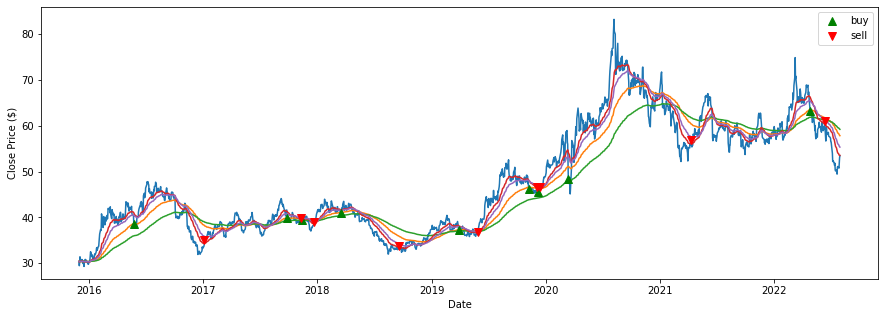

In [16]:
test_data = api.get_bars("UGL", TimeFrame.Day, start = "2008-01-01", adjustment='raw').df
test = Agent(test_data, [100,200,30,50])
test.execute()
test.plot()